In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'ravdess-emotional-speech-audio:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F107620%2F256618%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240609%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240609T084356Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D84c90a15419f7a3dc2101aa1970de38103cd6a72836eb867862bf5184f3124c179134fbc04f850133088763d0a7d91dc611aa0847b0ccaaa035b92b96fc2143deafedbd213d0267d447ddae766178b360bb77c3098f97366fcc0d6c11d6ab340806e06495018369b1cec73735d0dd161e37f89ac99a65e1ef5d95fdac6b26ad3083fa5c04b9396ea5eff87c3a6c932196b9d959fdf57d338106a4e32eb5f30958a6d997dbc7b482cbae9bd1bd2fe984206c5511ebb5309c53ddb3e9eae4fdc31ab9f967837d4e73fbfacf0bd3929f7c7edcb760c507ce70a3ae30802af597e58c41fcf36f16736f966b42b0561990b395f4dec7a1266dfe2a4cb62343a8eecc4'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 450102890 bytes downloaded
Downloaded and uncompressed: ravdess-emotional-speech-audio
Data source import complete.


In [ ]:
import pandas as pd
import numpy as np
import os
import sys
import random
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from IPython.display import Audio
import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, LSTM, Flatten, TimeDistributed, BatchNormalization, Activation, Bidirectional, Input
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.layers import Dropout
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [ ]:
Ravdess = "/kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/"

In [ ]:
ravdess_directory_list = os.listdir(Ravdess)
file_emotion = []
file_path = []
file_intensity = []

for dir in ravdess_directory_list:
    actor = os.listdir(Ravdess + dir)
    for file in actor:
        part = file.split('.')[0]
        part = part.split('-')
        file_emotion.append(int(part[2]))
        file_intensity.append(int(part[3]))
        file_path.append(Ravdess + dir + '/' + file)

Ravdess_df = pd.DataFrame({
    "Emotions": file_emotion,
    "Intensity": file_intensity,
    "Path": file_path
})

Ravdess_df.Emotions.replace({
    1: 'neutral', 2: 'calm', 3: 'happy', 4: 'sad',
    5: 'angry', 6: 'fear', 7: 'disgust', 8: 'surprise'
}, inplace=True)

Ravdess_df.Intensity.replace({1: 'normal', 2: 'strong'}, inplace=True)
Ravdess_df.head()

,Emotions,Intensity,Path
0,surprise,strong,/kaggle/input/ravdess-emotional-speech-audio/a...
1,calm,strong,/kaggle/input/ravdess-emotional-speech-audio/a...
2,happy,strong,/kaggle/input/ravdess-emotional-speech-audio/a...
3,angry,normal,/kaggle/input/ravdess-emotional-speech-audio/a...
4,surprise,strong,/kaggle/input/ravdess-emotional-speech-audio/a...


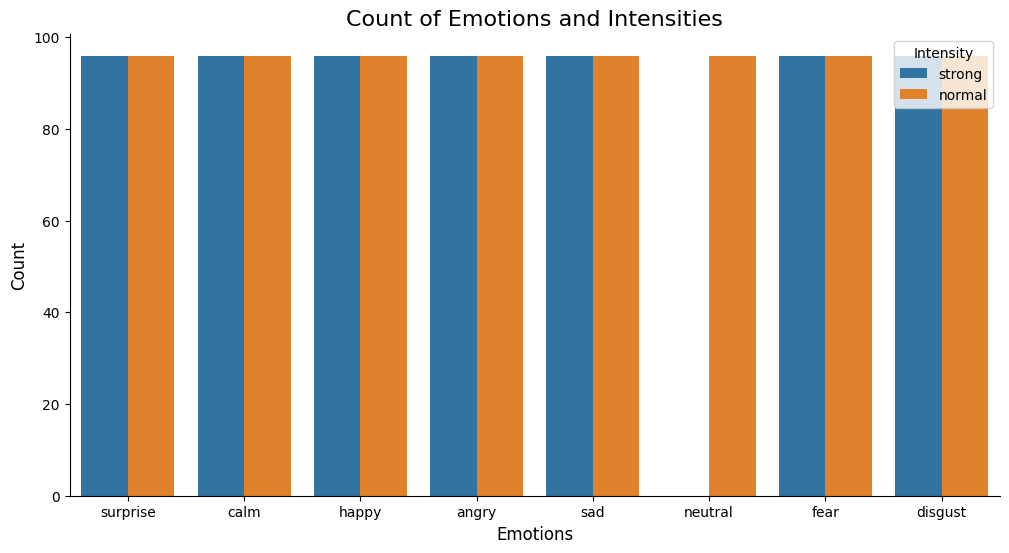

In [ ]:
plt.figure(figsize=(12, 6))
plt.title('Count of Emotions and Intensities', size=16)
sns.countplot(x='Emotions', hue='Intensity', data=Ravdess_df)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()


In [ ]:
def create_waveplot(data, sr):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio', size=15)
    librosa.display.waveshow(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr):
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio', size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
    plt.colorbar()


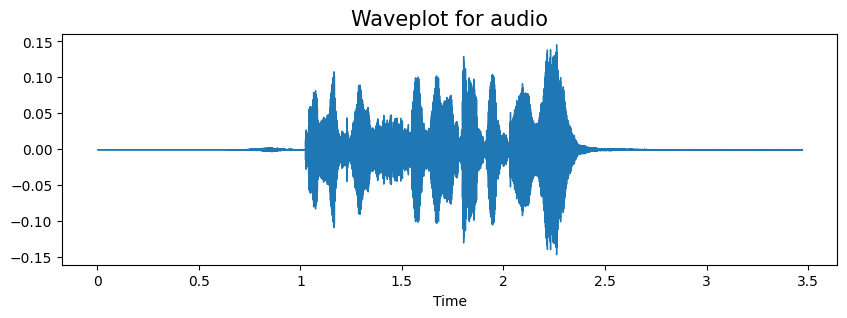

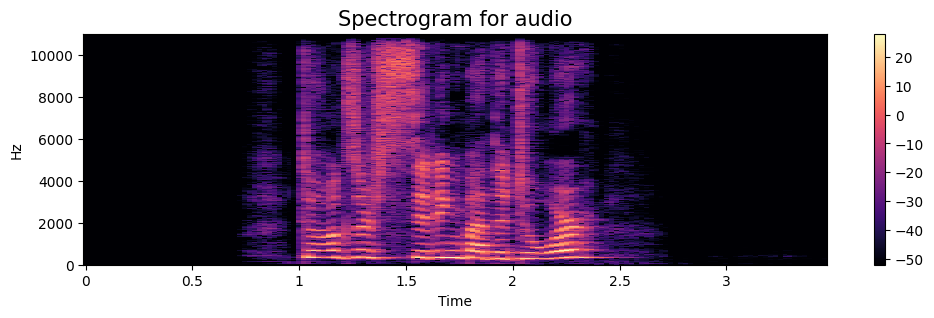

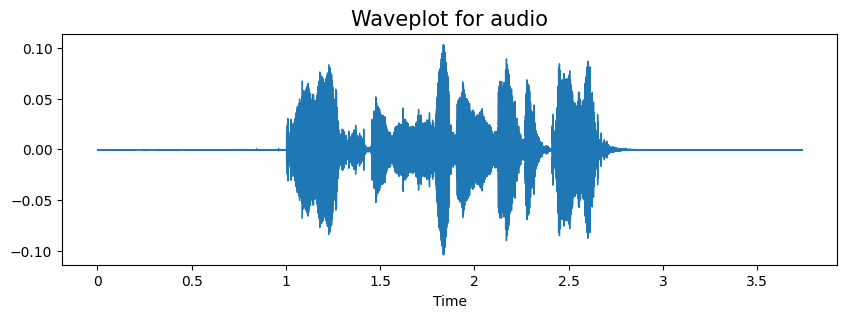

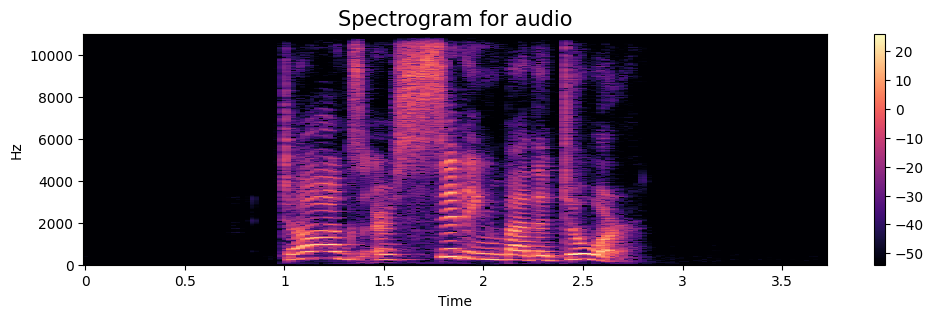

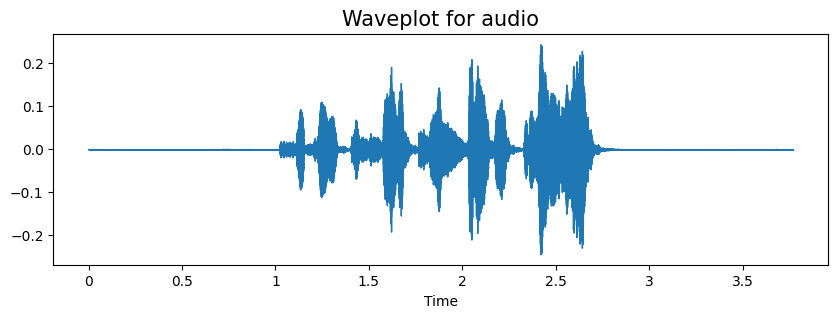

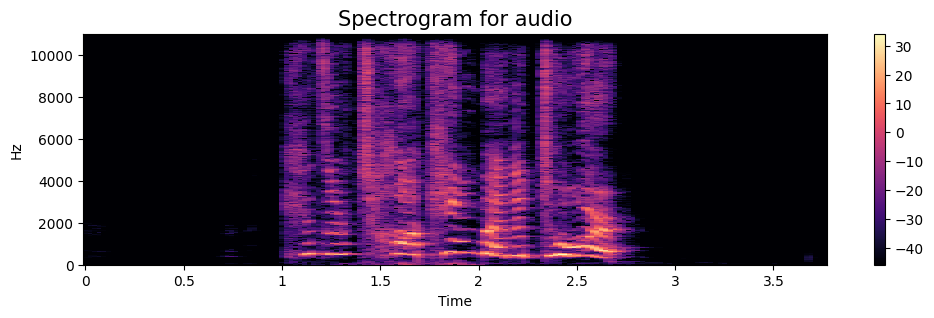

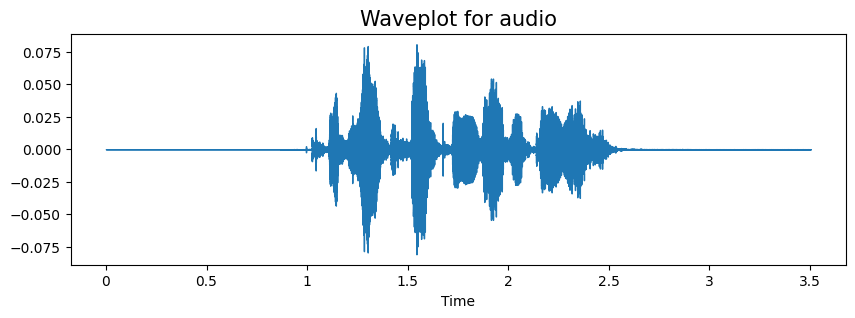

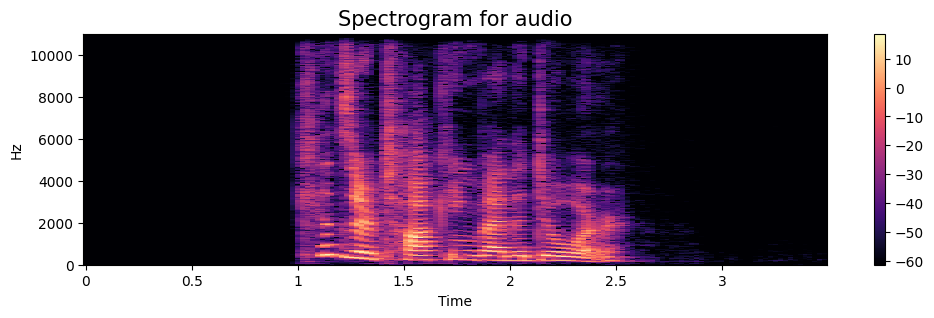

In [ ]:
for emotion in ['fear', 'angry', 'sad', 'happy']:
    path = np.array(Ravdess_df.Path[Ravdess_df.Emotions == emotion])[1]
    data, sampling_rate = librosa.load(path)
    create_waveplot(data, sampling_rate)
    create_spectrogram(data, sampling_rate)
    Audio(path)


In [ ]:
def noise(data):
    noise_amp = 0.005 * np.random.uniform() * np.amax(data)
    return data + noise_amp * np.random.normal(size=data.shape[0])

def stretch(data, rate=0.85):
    return librosa.effects.time_stretch(data, rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high=5) * 1000)
    return np.roll(data, shift_range)

def pitch(data, sample_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sample_rate, pitch_factor)

# Function to extract features
def extract_features(data, sample_rate, n_mfcc=13):
    mfccs = librosa.feature.mfcc(y=data, sr=sample_rate, n_mfcc=n_mfcc)
    return mfccs.T

In [ ]:
# Function to get features for each audio file
def get_features(path, duration=2.5, offset=0.5, n_mfcc=13):
    data, sample_rate = librosa.load(path, duration=duration, offset=offset)
    mfccs = extract_features(data, sample_rate, n_mfcc)
    return mfccs

# Sliding window function
def sliding_window(data, window_size, step_size):
    num_segments = int((len(data) - window_size) / step_size) + 1
    segments = []
    for start in range(0, num_segments * step_size, step_size):
        end = start + window_size
        segments.append(data[start:end])
    return np.array(segments)

In [ ]:
X = []
Y_emotion = []
Y_intensity = []
window_size = 50  # Change this to a suitable window size
step_size = 25   # Change this to a suitable step size

for path, emotion, intensity in zip(Ravdess_df.Path, Ravdess_df.Emotions, Ravdess_df.Intensity):
    features = get_features(path)
    feature_segments = sliding_window(features, window_size, step_size)
    for segment in feature_segments:
        X.append(segment)
        Y_emotion.append(emotion)
        Y_intensity.append(intensity)

X = np.array(X)
Y_emotion = np.array(Y_emotion)
Y_intensity = np.array(Y_intensity)

In [ ]:
X



array([[[-6.7633813e+02,  0.0000000e+00,  0.0000000e+00, ...,
          0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
        [-6.7633813e+02,  0.0000000e+00,  0.0000000e+00, ...,
          0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
        [-6.7633813e+02,  0.0000000e+00,  0.0000000e+00, ...,
          0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
        ...,
        [-3.9221027e+02, -7.6123756e+01,  5.2521248e+01, ...,
         -8.9759083e+00, -8.7362118e+00, -4.6745515e+00],
        [-3.6331314e+02, -5.1903076e+01,  5.5845810e+01, ...,
         -4.2254086e+00,  2.3519965e-01,  7.9206653e+00],
        [-2.3440378e+02, -3.4070145e+01, -2.1975296e+01, ...,
         -1.3302032e+01,  1.7291656e+01,  3.2563698e+01]],

       [[-2.0929115e+02,  9.0388596e+01, -1.6817087e+00, ...,
         -1.4490644e+01, -1.3981587e+01, -1.3751575e+01],
        [-2.4988745e+02,  6.9942871e+01, -1.3319086e+01, ...,
         -2.2651558e+01, -1.0862816e+01, -8.9736004e+00],
        [-2.3187683e+02, 

In [ ]:
Y_emotion



array(['surprise', 'surprise', 'surprise', ..., 'surprise', 'surprise',
       'surprise'], dtype='<U8')

In [ ]:
Y_intensity

array(['strong', 'strong', 'strong', ..., 'strong', 'strong', 'strong'],
      dtype='<U6')

In [ ]:
scaler = StandardScaler()
num_samples, time_steps, num_features = X.shape

X_scaled = np.zeros((num_samples, time_steps, num_features))

for i in range(num_samples):
    X_scaled[i] = scaler.fit_transform(X[i])

In [ ]:
encoder_emotion = OneHotEncoder()
encoder_intensity = OneHotEncoder()
Y_emotion_encoded = encoder_emotion.fit_transform(Y_emotion.reshape(-1, 1)).toarray()
Y_intensity_encoded = encoder_intensity.fit_transform(Y_intensity.reshape(-1, 1)).toarray()

In [ ]:
x_train, x_test, y_train_emotion, y_test_emotion, y_train_intensity, y_test_intensity = train_test_split(
    X_scaled, Y_emotion_encoded, Y_intensity_encoded, test_size=0.3, random_state=21
)


In [ ]:
input_shape = x_train.shape[1:]
num_emotions = Y_emotion_encoded.shape[1]
num_intensities = Y_intensity_encoded.shape[1]

In [ ]:
input_layer = Input(shape=input_shape)

lstm_layer = Bidirectional(LSTM(128, return_sequences=True))(input_layer)
lstm_layer = Dropout(0.5)(lstm_layer)

lstm_layer = Bidirectional(LSTM(64, return_sequences=False))(lstm_layer)
lstm_layer = Dropout(0.5)(lstm_layer)

dense_layer = Dense(32, activation='relu')(lstm_layer)
dense_layer = Dropout(0.5)(dense_layer)

emotion_output = Dense(num_emotions, activation='softmax', name='emotion_output')(dense_layer)
intensity_output = Dense(num_intensities, activation='softmax', name='intensity_output')(dense_layer)


In [ ]:
model = Model(inputs=input_layer, outputs=[emotion_output, intensity_output])

model.compile(optimizer='adam',
              loss={'emotion_output': 'categorical_crossentropy', 'intensity_output': 'categorical_crossentropy'},
              metrics={'emotion_output': 'accuracy', 'intensity_output': 'accuracy'})

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=5e-4)

In [ ]:
history = model.fit(
    x_train,
    {'emotion_output': y_train_emotion, 'intensity_output': y_train_intensity},
    validation_data=(x_test, {'emotion_output': y_test_emotion, 'intensity_output': y_test_intensity}),
    epochs=100, batch_size=32, callbacks=[early_stopping, reduce_lr]
)

# Evaluate the model
results = model.evaluate(
    x_test, {'emotion_output': y_test_emotion, 'intensity_output': y_test_intensity}
)



Epoch 1/100
95/95 [==============================] - 37s 312ms/step - loss: 2.7803 - emotion_output_loss: 2.0849 - intensity_output_loss: 0.6954 - emotion_output_accuracy: 0.1528 - intensity_output_accuracy: 0.5337 - val_loss: 2.7279 - val_emotion_output_loss: 2.0536 - val_intensity_output_loss: 0.6743 - val_emotion_output_accuracy: 0.1775 - val_intensity_output_accuracy: 0.5972 - lr: 0.0010
Epoch 2/100
95/95 [==============================] - 27s 282ms/step - loss: 2.7075 - emotion_output_loss: 2.0347 - intensity_output_loss: 0.6728 - emotion_output_accuracy: 0.1799 - intensity_output_accuracy: 0.5936 - val_loss: 2.6484 - val_emotion_output_loss: 2.0041 - val_intensity_output_loss: 0.6442 - val_emotion_output_accuracy: 0.2215 - val_intensity_output_accuracy: 0.6343 - lr: 0.0010
Epoch 3/100
95/95 [==============================] - 26s 270ms/step - loss: 2.6071 - emotion_output_loss: 1.9714 - intensity_output_loss: 0.6357 - emotion_output_accuracy: 0.2163 - intensity_output_accuracy: 0.

In [ ]:
# Print the results
if len(results) == 3:
    total_loss, emotion_loss, intensity_loss = results
    print(f"Total Loss: {total_loss:.2f}")
    print(f"Emotion Loss: {emotion_loss:.2f}")
    print(f"Intensity Loss: {intensity_loss:.2f}")
else:
    total_loss, emotion_loss, intensity_loss, emotion_acc, intensity_acc = results
    print(f"Total Loss: {total_loss:.2f}")
    print(f"Emotion Loss: {emotion_loss:.2f}")
    print(f"Intensity Loss: {intensity_loss:.2f}")
    print(f"Emotion Accuracy: {emotion_acc * 100:.2f}%")
    print(f"Intensity Accuracy: {intensity_acc * 100:.2f}%")

Total Loss: 2.05
Emotion Loss: 1.53
Intensity Loss: 0.52
Emotion Accuracy: 44.21%
Intensity Accuracy: 72.84%


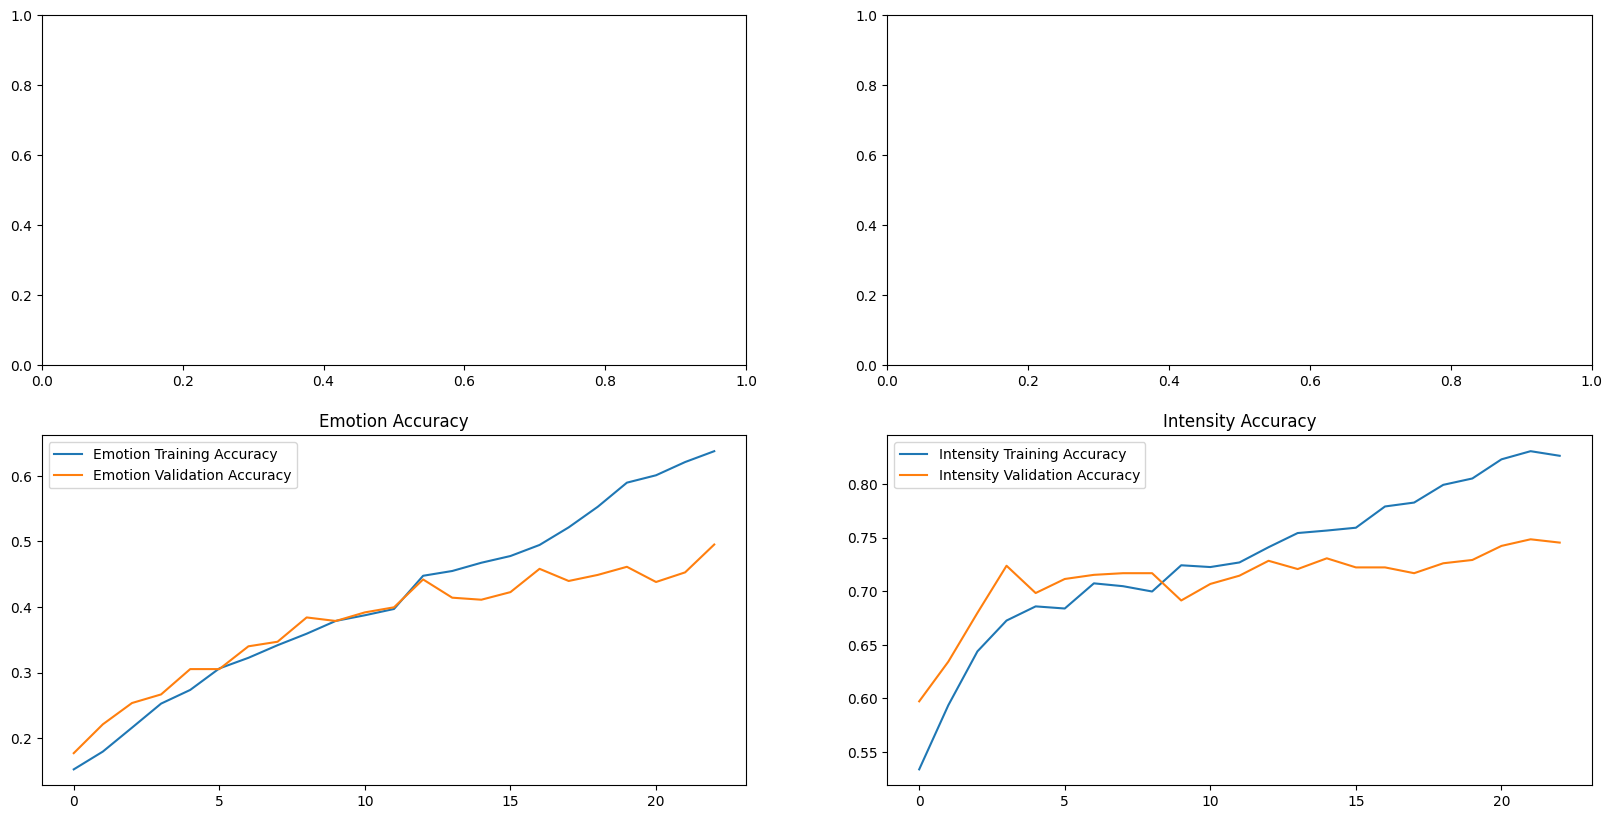

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(20, 10))



# Plot accuracy
ax[1, 0].plot(history.history['emotion_output_accuracy'], label='Emotion Training Accuracy')
ax[1, 0].plot(history.history['val_emotion_output_accuracy'], label='Emotion Validation Accuracy')
ax[1, 0].set_title('Emotion Accuracy')
ax[1, 0].legend()

ax[1, 1].plot(history.history['intensity_output_accuracy'], label='Intensity Training Accuracy')
ax[1, 1].plot(history.history['val_intensity_output_accuracy'], label='Intensity Validation Accuracy')
ax[1, 1].set_title('Intensity Accuracy')
ax[1, 1].legend()

plt.show()

1/1 [==============================] - 2s 2s/step


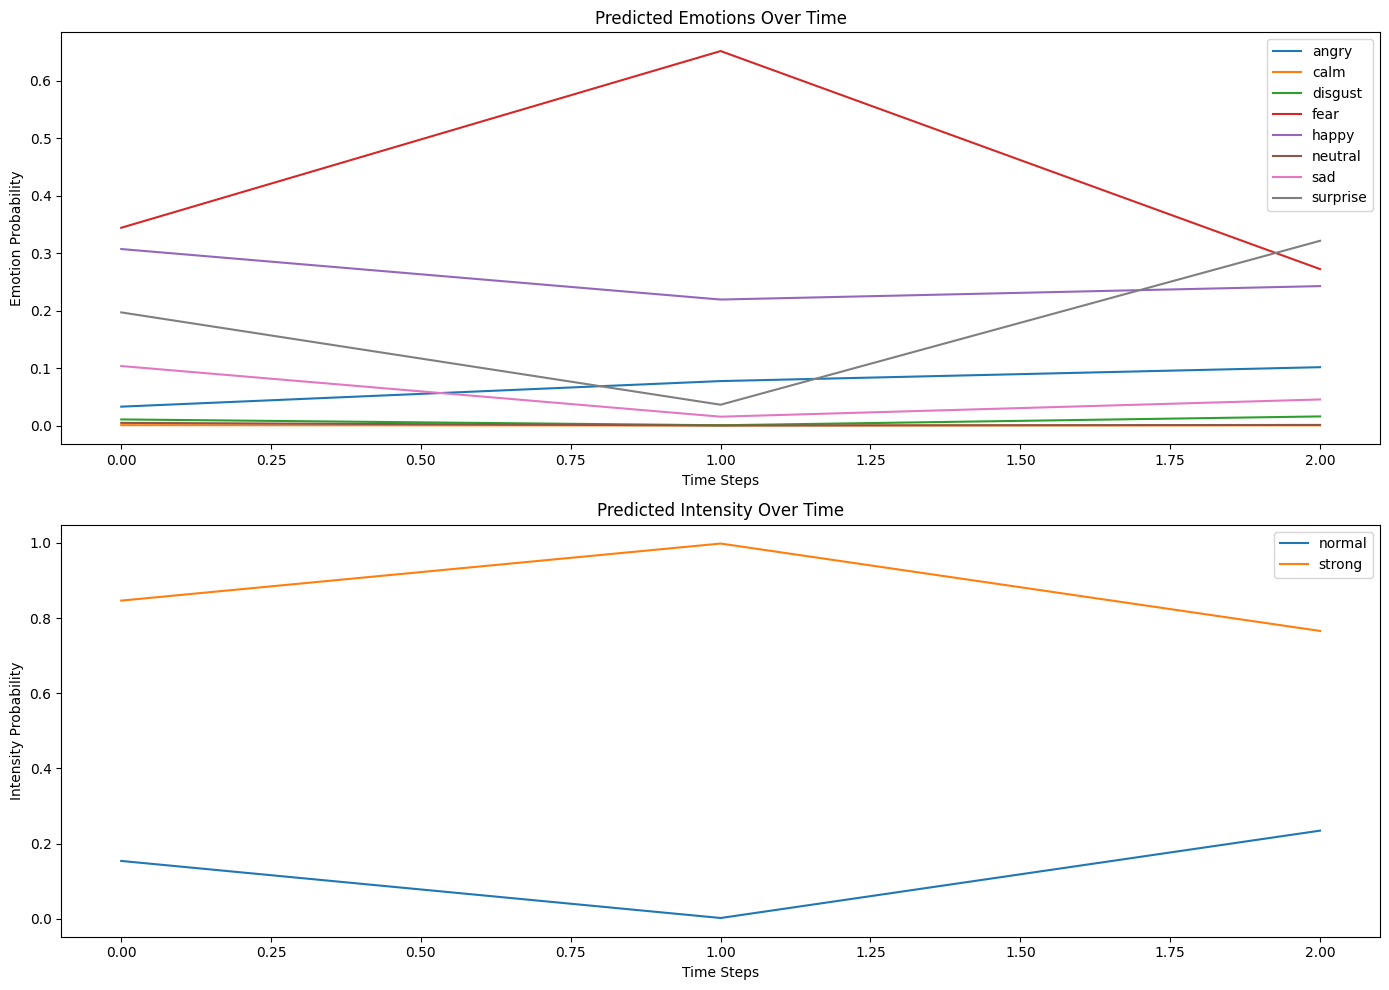

In [ ]:
def plot_predictions_over_time(y_pred_emotion, y_pred_intensity, time_steps):
    plt.figure(figsize=(14, 10))

    # Emotion predictions over time
    plt.subplot(2, 1, 1)
    for i, emotion in enumerate(encoder_emotion.categories_[0]):
        plt.plot(range(time_steps), y_pred_emotion[:, i], label=emotion)
    plt.title('Predicted Emotions Over Time')
    plt.xlabel('Time Steps')
    plt.ylabel('Emotion Probability')
    plt.legend()

    # Intensity predictions over time
    plt.subplot(2, 1, 2)
    for i, intensity in enumerate(encoder_intensity.categories_[0]):
        plt.plot(range(time_steps), y_pred_intensity[:, i], label=intensity)
    plt.title('Predicted Intensity Over Time')
    plt.xlabel('Time Steps')
    plt.ylabel('Intensity Probability')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Tahmin ve çizim
example_path = Ravdess_df.Path[0]
example_features = get_features(example_path)
example_segments = sliding_window(example_features, window_size, step_size)

example_segments_scaled = np.zeros((example_segments.shape[0], example_segments.shape[1], example_segments.shape[2]))
for i in range(example_segments.shape[0]):
    example_segments_scaled[i] = scaler.transform(example_segments[i])

y_pred_emotion, y_pred_intensity = model.predict(example_segments_scaled)

# Her bir zaman adımı için duygu ve yoğunluk tahminlerini çizme
plot_predictions_over_time(y_pred_emotion, y_pred_intensity, example_segments.shape[0])

In [ ]:
pip install streamlit


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 33.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 20.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 51.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.0/83.0 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.7 MB/s eta 0:00:00


In [ ]:
model.save("emotion_intensity_model.h5")